In [88]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from PIL import Image
from keras.layers import *
%matplotlib inline

In [2]:
import cv2

In [3]:
from vis.visualization import visualize_saliency, visualize_cam
from vis.utils import utils
from keras import activations
from keras.applications.vgg19 import VGG19

In [4]:
model = VGG19(input_shape=(224,224,3))

In [ ]:
# ip = Input((224,224,3))
# x = model(ip)
# x = Lambda(lambda x: 1-x)(x)
# model = Model(ip, x)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 1000)              143667240 
_________________________________________________________________
lambda_1 (Lambda)            (None, 1000)              0         
Total params: 143,667,240
Trainable params: 143,667,240
Non-trainable params: 0
_________________________________________________________________


In [7]:
layer_idx = utils.find_layer_idx(model, 'predictions')
# model.layers[layer_idx].activation = activations.softmax

/home/met/ug/16144001/miniconda3/envs/tfcpu/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


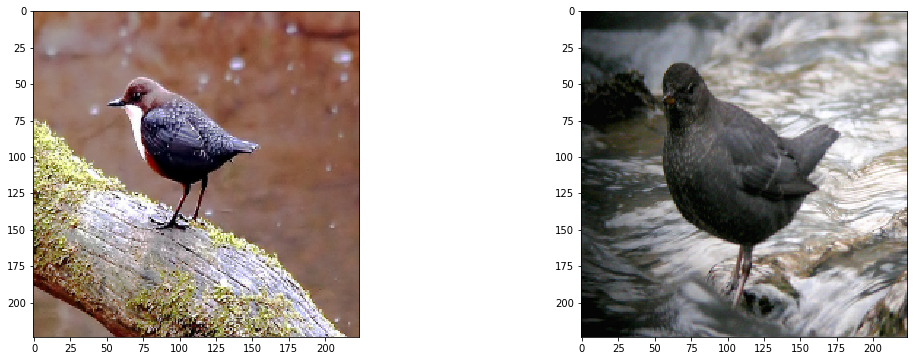

In [9]:
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('ouzel2.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

In [10]:
img1.shape

(224, 224, 3)

# VGG19

In [11]:
np.argmax(model.predict(img1.reshape(1, 224, 224, 3)), axis=-1)

array([20])

### Try adding a Lambda layer that is 1 - output of previous layer, then find saliency map and then subtract that from this

/home/met/ug/16144001/miniconda3/envs/tfcpu/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<Figure size 1296x432 with 0 Axes>

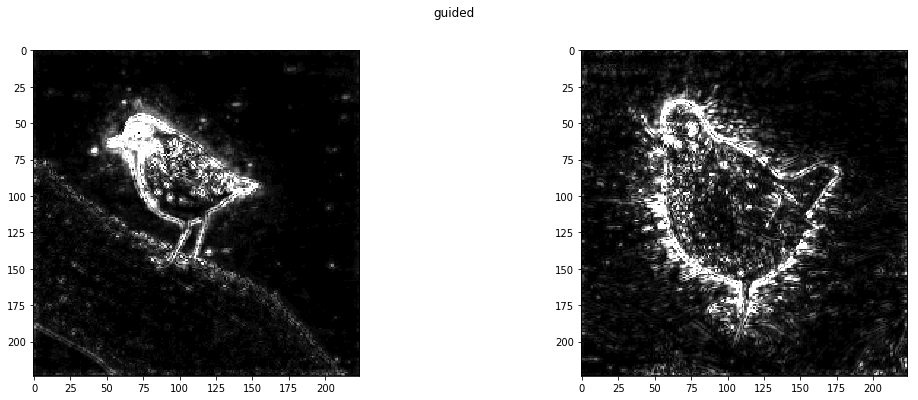

In [12]:
res = []
for modifier in ['guided']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    indx = [603, 508]
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        #603 horse
        #878, 508 keyboard
#         ind = np.argmax(model.predict(img.reshape(1, 224, 224, 3)), axis=-1)
        grads = visualize_saliency(model, layer_idx, filter_indices=20, 
                                   seed_input=img, backprop_modifier=modifier)
        res.append(grads)
        # Lets overlay the heatmap onto original image.   
        # In the paper they took maximum value of gradient across channels for each pixel
        ax[i].imshow(np.max(grads, axis=-1), cmap='gray')

# 

In [127]:
h = np.max(res[0], axis=-1)

In [102]:
smap = np.zeros((224,224), dtype='uint8')

In [103]:
smap[h>=250] = 1

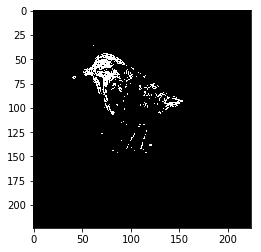

In [113]:
plt.imshow(h.clip(250,255), cmap='gray')

In [173]:
def segment(img, smap):
#     img = img[:,:,::-1]
    mask = np.zeros(img.shape[:2],np.uint8)
    print(mask.shape)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    # newmask is the mask image I manually labelled
    # newmask = cv2.imread('newmask.png',0)
    up = np.percentile(smap, 96)
    down = np.percentile(smap, 30)
    mask[smap >= up] = 1
    mask[smap <= up] = 2
    mask[smap <= down] = 0

    # plt.imshow(mask)
    # whereever it is marked white (sure foreground), change mask=1
    # whereever it is marked black (sure background), change mask=0
    # mask[newmask == 0] = 0
    # mask[newmask == 255] = 1
    # rec = (x, y, w, h)

    mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,3,cv2.GC_INIT_WITH_MASK)

    mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask[:,:,np.newaxis]
    return img, mask

In [174]:
out = segment(img1, smap=h)

(224, 224)


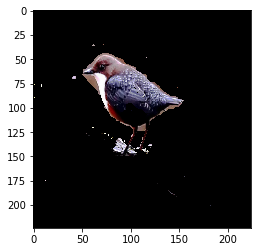

In [175]:
plt.imshow(out[0])

# Weakly Supervised Learning of Part Selection Model with Spatial Constraints for Fine-Grained Image Classification

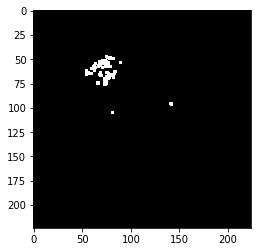

In [109]:
kernel = np.ones((3,3),np.uint8)
smap = cv2.morphologyEx(smap, cv2.MORPH_OPEN, kernel)
plt.imshow(smap, cmap='gray')

In [72]:
def get_box(mask):
    left_col_idx = []
    empty = True
    for i, row in enumerate(mask):
        for cell in row:
            if cell == 1:
                empty = False
                break
        left_col_idx.append(i)
        if not empty:
            break
    mask = np.delete(mask, left_col_idx, axis=0)
    print(mask.shape)

    right_col_idx = []
    empty = True
    for i in range(len(mask)-1, -1, -1):
        for cell in mask[i]:
            if cell == 1:
                empty = False
                break
        right_col_idx.append(i)
        if not empty:
            break
    mask = np.delete(mask, right_row_idx, axis=0)
    print(mask.shape)

    top_row_idx = []
    empty = True
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            if mask[j][i] == 1:
                empty = False
                break
        top_row_idx.append(i)
        if not empty:
            break
    mask = np.delete(mask, top_row_idx, axis=1)
    print(mask.shape)

    bottom_row_idx = []
    empty = True
    for i in range(mask.shape[1]-1, -1, -1):
        for j in range(mask.shape[0]):
            if mask[j][i] == 1:
                empty = False
                break
        bottom_row_idx.append(i)
        if not empty:
            break
    mask = np.delete(mask, bottom_row_idx, axis=1)
    print(mask.shape)
    return (left_col_idx[-1], top_row_idx[-1], mask.shape[0], mask.shape[1])

(109, 183)


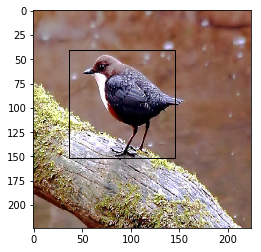

In [89]:
x,y,w,y = get_box(h)
ax = plt.gca()
rec = patches.Rectangle((x,y), w, h, fill=None)
ax.add_patch(rec)
ax.imshow(img1)

## Other Random Experiments

<Figure size 432x288 with 0 Axes>

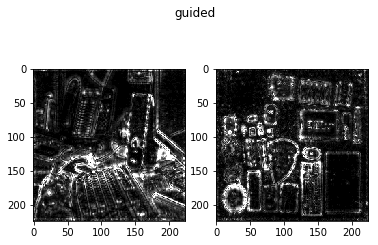

In [42]:
for modifier in ['guided']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    indx = [603, 508]
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        #603 horse
        #878, 508 keyboard
#         ind = np.argmax(model.predict(img.reshape(1, 224, 224, 3)), axis=-1)
        grads = visualize_saliency(model, layer_idx, filter_indices=878, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.   
        # In the paper they took maximum value of gradient across channels for each pixel
        ax[i].imshow(np.max(grads, axis=-1), cmap='gray')

In [49]:
j = np.max(grads, axis=-1)

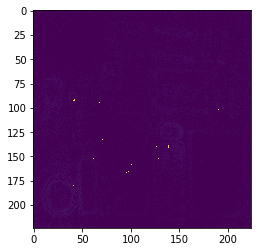

In [50]:
plt.imshow(h-j)

In [36]:
pen_layer_idx = utils.find_layer_idx(model, 'block3_conv4')

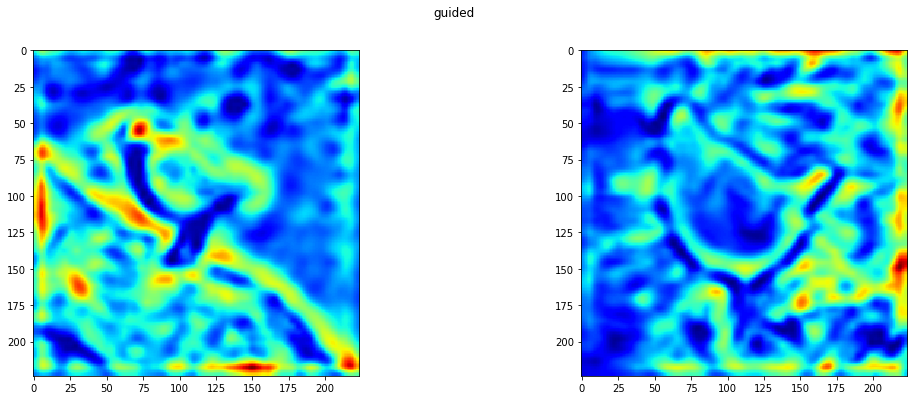

In [37]:
for modifier in ['guided']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
#         ind = np.argmax(model.predict(img.reshape(1, 224, 224, 3)), axis=-1)
        grads = visualize_cam(model, layer_idx, filter_indices=20, penultimate_layer_idx=pen_layer_idx,
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.   
        # In the paper they took maximum value of gradient across channels for each pixel
        ax[i].imshow(grads)